# Multi-Output Model
[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'
df = pd.read_excel(URL)

In [3]:
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [4]:
df.sample(frac=1).reset_index(drop=True)

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.86,588.0,294.0,147.00,7.0,2,0.25,2,29.34,33.37
1,0.98,514.5,294.0,110.25,7.0,3,0.10,3,24.40,26.02
2,0.62,808.5,367.5,220.50,3.5,4,0.10,2,12.97,14.27
3,0.64,784.0,343.0,220.50,3.5,5,0.10,2,15.19,19.30
4,0.71,710.5,269.5,220.50,3.5,3,0.40,4,14.70,17.20
...,...,...,...,...,...,...,...,...,...,...
763,0.64,784.0,343.0,220.50,3.5,4,0.40,3,18.48,21.54
764,0.76,661.5,416.5,122.50,7.0,3,0.25,1,36.13,37.58
765,0.98,514.5,294.0,110.25,7.0,2,0.10,3,24.28,25.68
766,0.82,612.5,318.5,147.00,7.0,5,0.10,2,22.79,28.79


In [5]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2)

In [6]:
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()

In [7]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2

def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

In [8]:
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

# Modeling

In [9]:
input = tf.keras.layers.Input(shape=(len(train.columns),))
x1 = tf.keras.layers.Dense(128,activation='relu')(input)
x1 = tf.keras.layers.Dense(128,activation='relu')(x1)
y1 = tf.keras.layers.Dense(1,name='y1')(x1)
x1 = tf.keras.layers.Dense(64,activation='relu')(x1)
y2 = tf.keras.layers.Dense(1,name='y2')(x1)

model = tf.keras.models.Model(inputs=input, outputs=[y1,y2])

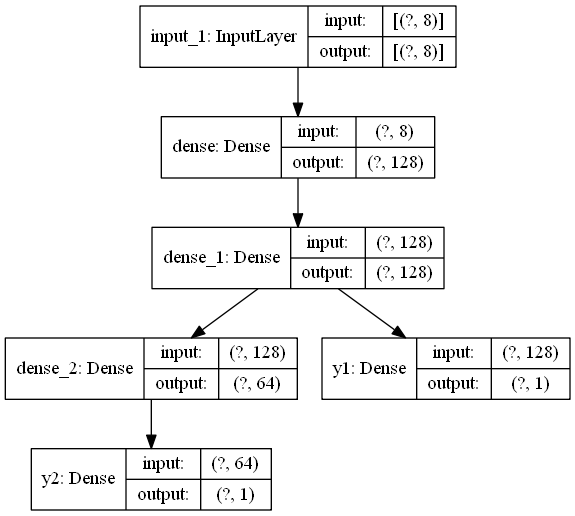

In [10]:
from tensorflow.python.keras.utils.vis_utils import plot_model
import pydot
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

In [19]:
#same loss function for both o/p
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.001),
             loss='mse',
             metrics=['mse']
             )

history = model.fit(norm_train_X, train_Y,
                    epochs=5)

Train on 614 samples
Epoch 1/5
614/614 [==============================] - 0s 162us/sample - loss: 0.8450 - y1_loss: 0.1419 - y2_loss: 0.6743 - y1_mse: 0.1459 - y2_mse: 0.6991
Epoch 2/5
614/614 [==============================] - 0s 44us/sample - loss: 0.8335 - y1_loss: 0.1605 - y2_loss: 0.7132 - y1_mse: 0.1588 - y2_mse: 0.6747
Epoch 3/5
614/614 [==============================] - 0s 63us/sample - loss: 0.8267 - y1_loss: 0.1819 - y2_loss: 0.6390 - y1_mse: 0.1878 - y2_mse: 0.6389
Epoch 4/5
614/614 [==============================] - 0s 42us/sample - loss: 1.4571 - y1_loss: 0.2623 - y2_loss: 1.2084 - y1_mse: 0.2614 - y2_mse: 1.1958
Epoch 5/5
614/614 [==============================] - 0s 63us/sample - loss: 2.7900 - y1_loss: 0.4026 - y2_loss: 2.3269 - y1_mse: 0.4156 - y2_mse: 2.3744


In [20]:
#different loss function for Outputs
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.001),
             loss={'y1':'mse', 'y2':'mae'},
             metrics={'y1':'mse','y2':'mae'}
             )

history = model.fit(norm_train_X, train_Y,
                    epochs=5)

Train on 614 samples
Epoch 1/5
614/614 [==============================] - 0s 170us/sample - loss: 0.6531 - y1_loss: 0.1403 - y2_loss: 0.5154 - y1_mse: 0.1319 - y2_mae: 0.5212
Epoch 2/5
614/614 [==============================] - 0s 54us/sample - loss: 0.6086 - y1_loss: 0.1400 - y2_loss: 0.4818 - y1_mse: 0.1363 - y2_mae: 0.4723
Epoch 3/5
614/614 [==============================] - 0s 49us/sample - loss: 0.5823 - y1_loss: 0.1400 - y2_loss: 0.4428 - y1_mse: 0.1392 - y2_mae: 0.4431
Epoch 4/5
614/614 [==============================] - 0s 54us/sample - loss: 0.5736 - y1_loss: 0.1290 - y2_loss: 0.4494 - y1_mse: 0.1263 - y2_mae: 0.4473
Epoch 5/5
614/614 [==============================] - 0s 51us/sample - loss: 0.6188 - y1_loss: 0.1373 - y2_loss: 0.5113 - y1_mse: 0.1297 - y2_mae: 0.4892


# Evaluate the model